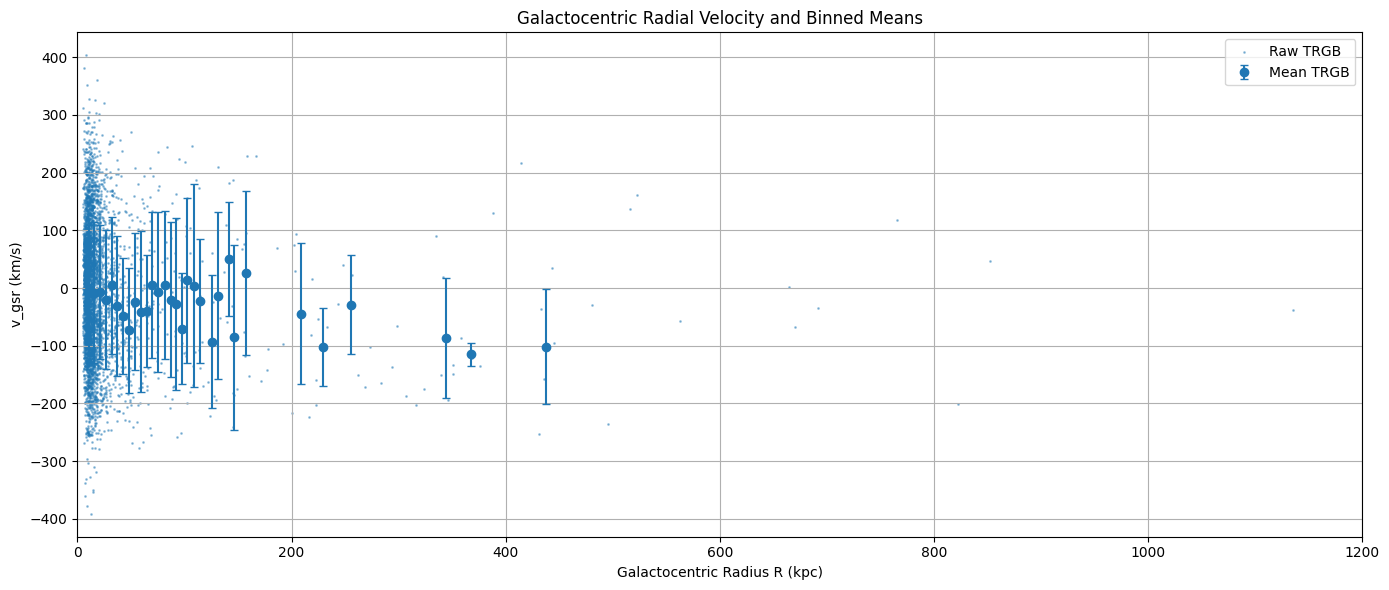

[TRGB] < 200 kpc: a = 6.66178e-03, b = -1.90195
[TRGB] ≥ 200 kpc: a = 2.19779e-03, b = -0.36014


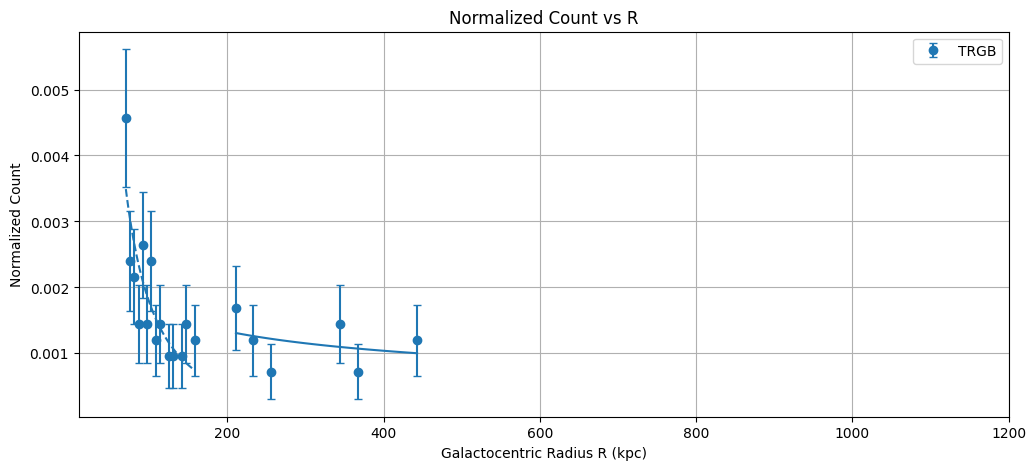

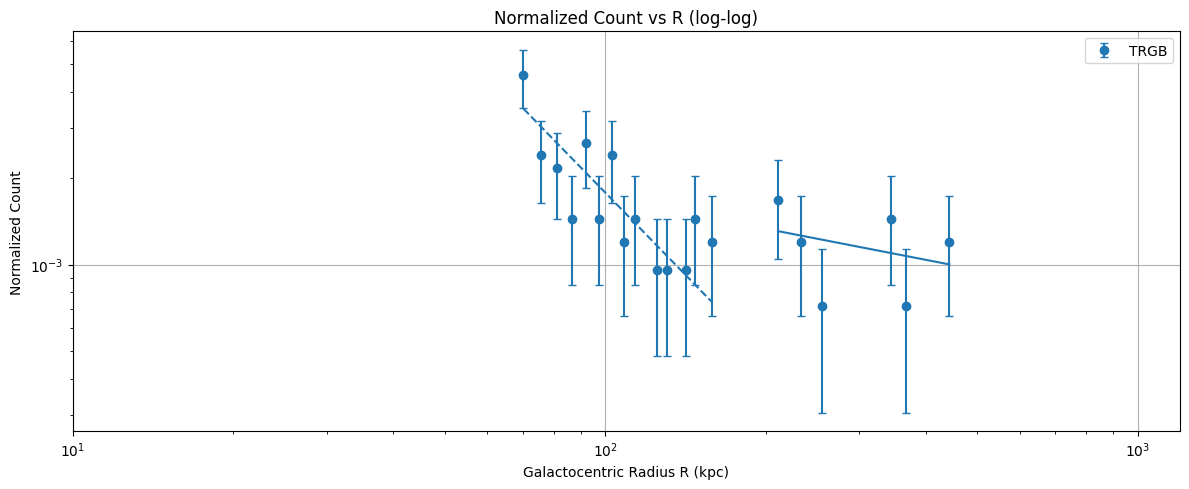

KeyError: 'b_s'

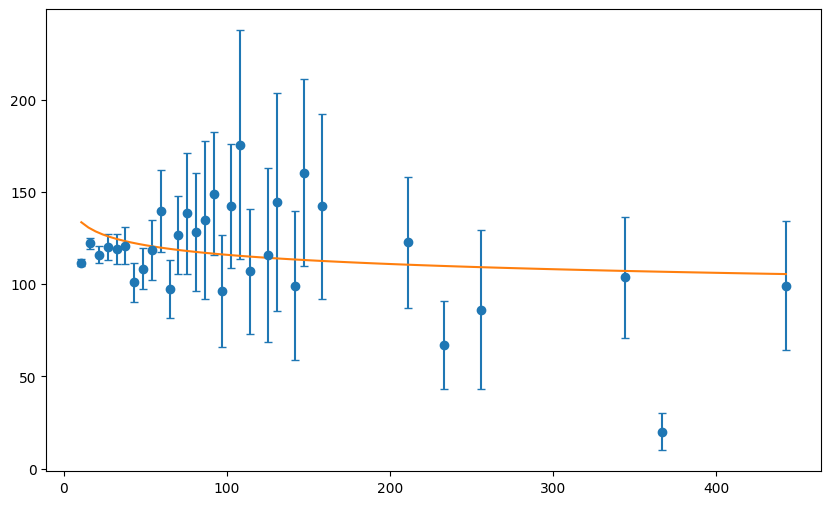

<Figure size 1000x600 with 0 Axes>

In [ ]:
import numpy as np
import pandas as pd
import astropy.units as u
from astropy.coordinates import SkyCoord, Galactocentric
from scipy.stats import binned_statistic
from scipy.optimize import curve_fit
import matplotlib.pyplot as plt

# Constants
U_sun, V_sun, W_sun = 11.1 * u.km/u.s, 12.24 * u.km/u.s, 7.25 * u.km/u.s
V0, R0 = 229 * u.km/u.s, 8.1 * u.kpc

# Coordinate transformation
def transform_to_galactocentric(ra, dec, distance, pm_ra_cosdec, pm_dec, rv):
    icrs = SkyCoord(ra=ra, dec=dec, distance=distance,
                    pm_ra_cosdec=pm_ra_cosdec, pm_dec=pm_dec,
                    radial_velocity=rv)
    galcen = icrs.transform_to(
        Galactocentric(galcen_distance=R0, z_sun=z_sun,
                       galcen_v_sun=[U_sun, V_sun, W_sun])
    )
    X, Y, Z = galcen.x.value, galcen.y.value, galcen.z.value
    U, V, W = galcen.v_x.value, galcen.v_y.value, galcen.v_z.value
    r = np.sqrt(X**2 + Y**2 + Z**2)
    phi = np.arctan2(Y, X)
    theta = np.pi / 2 - np.arctan2(Z, np.sqrt(X**2 + Y**2))
    V_r = (U * np.cos(phi) + V * np.sin(phi)) * np.sin(theta) + W * np.cos(theta)
    V_theta = (U * np.cos(phi) + V * np.sin(phi)) * np.cos(theta) - W * np.sin(theta)
    V_phi = U * np.sin(phi) - V * np.cos(phi)
    R_xy = np.sqrt(X**2 + Y**2+Z**2)
    return r, Z, V_r, V_theta, V_phi, R_xy, rv

# Define the power-law function
def power_law(x, a, b):
    return a * (x / 50)**b

# Binning and processing per file
def process_file(file_path, label, custom_bins):
    # 1. Load and clean
    df = pd.read_csv(file_path)
    required_cols = [
        'ra', 'dec', 'parallax', 'pmra', 'pmdec',
        'radial_velocity', 'l', 'b', 'parallax_error', 'bp_rp'
    ]
    df = df.dropna(subset=required_cols)
    df = df[(df['bp_rp'] > 1.3) & (df['bp_rp'] < 3)]

    # 2. Convert to astropy quantities
    ra = df['ra'].values * u.deg
    dec = df['dec'].values * u.deg
    distance = (df['parallax'].values * u.mas).to(u.kpc, u.parallax())
    pm_ra_cosdec = df['pmra'].values * u.mas/u.yr
    pm_dec = df['pmdec'].values * u.mas/u.yr
    rv = df['radial_velocity'].values * u.km/u.s
    l = df['l'].values * u.deg
    b = df['b'].values * u.deg

    # 3. Transform to Galactocentric (assumes you have this function defined)
    r, z, V_r, V_theta, V_phi, R_xy, rv = transform_to_galactocentric(
        ra, dec, distance, pm_ra_cosdec, pm_dec, rv
    )

    # 4. Spatial and velocity sigma clipping
    spatial_mask = (np.abs(z) > 5) & ~(z < 0)

    R_valid = R_xy[spatial_mask]
    rv_valid = rv[spatial_mask].value
    l_valid = l[spatial_mask]
    b_valid = b[spatial_mask]
    distance_valid = distance[spatial_mask]

    # 5. Compute V_gsr and V_circ
    v_gsr = (rv_valid
             + U_sun.value * np.cos(b_valid) * np.cos(l_valid)
             + V_sun.value * np.cos(b_valid) * np.sin(l_valid)
             + W_sun.value * np.sin(b_valid)
             + V0.value * np.cos(b_valid) * np.sin(l_valid))

    v_circ = (R_valid / R0.value) * ((v_gsr / (np.sin(l_valid) * np.cos(b_valid))) + V0.value)

    # 6. Bin statistics on V_gsr with custom bins
    mask = ~np.isnan(R_valid) & ~np.isnan(v_gsr) & (R_valid <= custom_bins[-1])
    R_valid_clean, v_gsr_clean = R_valid[mask], v_gsr[mask]

    mean_x, _, _ = binned_statistic(R_valid_clean, R_valid_clean, bins=custom_bins, statistic='mean')
    mean_y, _, _ = binned_statistic(R_valid_clean, v_gsr_clean, bins=custom_bins, statistic='mean')
    std_y, _, _ = binned_statistic(R_valid_clean, v_gsr_clean, bins=custom_bins, statistic='std')
    count, _, _ = binned_statistic(R_valid_clean, v_gsr_clean, bins=custom_bins, statistic='count')
    bin_centers = 0.5 * (custom_bins[:-1] + custom_bins[1:])

    # Prepare spatial velocities for anisotropy calculation
    r_spatial = r[spatial_mask]
    V_r_spatial = V_r[spatial_mask]
    V_th_spatial = V_theta[spatial_mask]
    V_ph_spatial = V_phi[spatial_mask]

    # 7. Robust dispersion estimator
    def robust_sigma(data):
        y = np.array(data, dtype=float).ravel()
        if y.size == 0:
            return np.nan
        y0 = np.median(y)
        mad = np.median(np.abs(y - y0)) / 0.6745
        if mad < 1e-20:
            mad = np.mean(np.abs(y - y0)) / 0.80
        u = (y - y0) / (6.0 * mad)
        mask_u = np.abs(u) <= 1.0
        if mask_u.sum() < 3:
            return np.nan
        u2 = u[mask_u]**2
        y_core = y[mask_u]
        num = np.sum((y_core - y0)**2 * (1 - u2)**4)
        den = np.sum((1 - u2) * (1 - 5.0 * u2))
        sigma2 = len(y) * num / (den * (den - 1))
        return np.sqrt(sigma2) if sigma2 > 0 else 0.0

    # 8. Compute binned stats for velocity components using custom bins
    def compute_binned_stats_custom(r, v, bins):
        stats = []
        for i in range(len(bins) - 1):
            mask = (r >= bins[i]) & (r < bins[i + 1])
            if np.sum(mask) >= 3:
                v_bin = v[mask]
                sig = robust_sigma(v_bin)
                err = sig / np.sqrt(2 * (np.sum(mask) - 1))
                med = np.median(v_bin)
            else:
                sig = err = med = np.nan
            stats.append((med, sig, err))
        return np.array(stats).T

    medVr, sigVr, errVr = compute_binned_stats_custom(r_spatial, V_r_spatial, custom_bins)
    medVt, sigVt, errVt = compute_binned_stats_custom(r_spatial, V_th_spatial, custom_bins)
    medVp, sigVp, errVp = compute_binned_stats_custom(r_spatial, V_ph_spatial, custom_bins)

    # 9. Anisotropy beta and error propagation
    beta = 1 - (sigVt**2 + sigVp**2) / (2 * sigVr**2)
    d_beta_dsr = (sigVt**2 + sigVp**2) / (sigVr**3)
    d_beta_dst = -sigVt / (sigVr**2)
    d_beta_dsp = -sigVp / (sigVr**2)
    beta_err = np.sqrt((d_beta_dsr * errVr)**2 +
                       (d_beta_dst * errVt)**2 +
                       (d_beta_dsp * errVp)**2)

    # 10. Return results
    return R_valid_clean, v_gsr_clean, pd.DataFrame({
        'Bin Center': bin_centers,
        'Mean X': mean_x,
        'Mean Y': mean_y,
        'Std Y': std_y,
        'Num Points': count,
        'Beta': beta,
        'Beta Error': beta_err,
        'Label': label,
    }).dropna()


# Define per-file configs
file_configs = [
    {
        'path': 'TRGB_Gaia_new-result.csv',
        'label': 'TRGB',
        'bins': np.concatenate([
            np.linspace(8, 100, 18),
            np.linspace(100, 150, 10)[1:], np.linspace(150, 200, 10)[1:],
            np.linspace(200, 400, 10)[1:], np.linspace(400, 600, 8)[1:],
            np.linspace(600, 800, 5)[1:], np.linspace(800, 1000, 3)[1:],
            np.linspace(1000, 1200, 2)[1:]
        ])
    },
    # {
    #     'path': 'LPV_Gaia_new-result.csv',
    #     'label': 'LPV',
    #     'bins': np.concatenate([
    #         np.linspace(8, 100, 10),
    #         np.linspace(100, 150, 10)[1:], np.linspace(150, 200, 10)[1:],
    #         np.linspace(200, 400, 10)[1:], np.linspace(400, 600, 8)[1:],
    #         np.linspace(600, 800, 5)[1:], np.linspace(800, 1000, 3)[1:],
    #         np.linspace(1000, 1200, 2)[1:]
    #     ])
    # }
]

# Plot 1: v_gsr and mean v_gsr
plt.figure(figsize=(14, 6))
for config in file_configs:
    R, v_gsr, binned = process_file(config['path'], config['label'], config['bins'])
    plt.scatter(R, v_gsr, s=1, alpha=0.4, label=f'Raw {config["label"]}')
    plt.errorbar(binned['Mean X'], binned['Mean Y'], yerr=binned['Std Y'], fmt='o', capsize=3,
                 label=f'Mean {config["label"]}')
plt.xlabel('Galactocentric Radius R (kpc)')
plt.ylabel('v_gsr (km/s)')
plt.title('Galactocentric Radial Velocity and Binned Means')
plt.xlim(0, 1200)
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

colors = ['tab:blue', 'tab:orange', 'tab:green', 'tab:red']

fig3, ax3 = plt.subplots(figsize=(12, 5))  # Normalized count (linear)
fig4, ax4 = plt.subplots(figsize=(12, 5))  # Normalized count (log-log)
for i, config in enumerate(file_configs):
    try:
        R, v_gsr, binned_df = process_file(config['path'], config['label'], config['bins'])
        color = colors[i % len(colors)]

       
        # Power-law fit
        r_bin = binned_df['Bin Center'].values
        n_tr = binned_df['Num Points'].values / len(R)
        valid_mask = r_bin >= 70
        r_bin_valid, n_tr_valid = r_bin[valid_mask], n_tr[valid_mask]

        # Low and high radius mask
        r_bin_low, n_tr_low = r_bin_valid[r_bin_valid < 200], n_tr_valid[r_bin_valid < 200]
        r_bin_high, n_tr_high = r_bin_valid[r_bin_valid >= 200], n_tr_valid[r_bin_valid >= 200]

        popt_low, _ = curve_fit(power_law, r_bin_low, n_tr_low, p0=(1, 1))
        popt_high, _ = curve_fit(power_law, r_bin_high, n_tr_high, p0=(1, 1))

        # Fit curves
        x_fit_low = np.linspace(r_bin_low.min(), r_bin_low.max(), 100)
        x_fit_high = np.linspace(r_bin_high.min(), r_bin_high.max(), 100)
        y_fit_low = power_law(x_fit_low, *popt_low)
        y_fit_high = power_law(x_fit_high, *popt_high)

        ax3.errorbar(r_bin_valid, n_tr_valid, yerr=np.sqrt(n_tr_valid/len(R)), fmt='o', capsize=3, label=f'{config["label"]}', color=color)
        ax3.plot(x_fit_low, y_fit_low, '--', color=color)
        ax3.plot(x_fit_high, y_fit_high, '-', color=color)

        ax4.errorbar(r_bin_valid, n_tr_valid, yerr=np.sqrt(n_tr_valid/len(R)), fmt='o', capsize=3, label=f'{config["label"]}', color=color)
        ax4.plot(x_fit_low, y_fit_low, '--', color=color)
        ax4.plot(x_fit_high, y_fit_high, '-', color=color)

        print(f"[{config['label']}] < 200 kpc: a = {popt_low[0]:.5e}, b = {popt_low[1]:.5f}")
        print(f"[{config['label']}] ≥ 200 kpc: a = {popt_high[0]:.5e}, b = {popt_high[1]:.5f}")

    except Exception as e:
        print(f"Error processing {config['label']}: {e}")

# Finalize plots
for ax, title, ylab, xlog, ylog in zip(
    [ax3, ax4],
    [ 'Normalized Count vs R', 'Normalized Count vs R (log-log)'],
    ['Normalized Count', 'Normalized Count'],
    [ False, True],
    [False, True]
):
    ax.set_xlabel('Galactocentric Radius R (kpc)')
    ax.set_ylabel(ylab)
    ax.set_title(title)
    ax.legend()
    ax.grid(True)
    if xlog: ax.set_xscale('log')
    if ylog: ax.set_yscale('log')
    ax.set_xlim(10, 1200)

plt.tight_layout()
plt.show()


# Plot 2: Std_Y vs Bin Center with power law fit (overplot)
plt.figure(figsize=(10, 6))
for config in file_configs:
    _, _, binned = process_file(config['path'], config['label'], config['bins'])

    r_bin = binned['Bin Center']
    s_gsr = binned['Std Y']
    N = np.array(binned['Num Points'])
    error_bars = np.sqrt(1 / (2 * (N - 1))) * s_gsr

    popt, _ = curve_fit(power_law, r_bin, s_gsr, p0=(1, 1))
    fitted_a, fitted_b = popt
    x_fit = np.linspace(min(r_bin), max(r_bin), 100)
    y_fit = power_law(x_fit, fitted_a, fitted_b)

    plt.errorbar(r_bin, s_gsr, yerr=error_bars, fmt='o', label=f'{config["label"]} Data', capsize=3)
    plt.plot(x_fit, y_fit, label=f'{config["label"]} Fit: $y = {fitted_a:.2f} x^{{{fitted_b:.2f}}}$')


def compute_v_c(r, std_y, N, fitted_b_low, fitted_b_high, fitted_b_s, label):
    H_r = (r**2 + R0**2) / (4 * r**2) - ((r**2 - R0**2)**2) / (8 * r**3 * R0) * np.log(np.abs((r + R0) / (r - R0)))
    sigma_r = std_y / np.sqrt(1 - beta * H_r)
    dln_ntr_dlR = np.where(r.value < 200, fitted_b_low, fitted_b_high)
    dln_sigma_r2_dlR = np.where(r.value < 200, fitted_b_s, fitted_b_s)
    V_c = np.sqrt(np.abs(-sigma_r**2 * (dln_ntr_dlR + dln_sigma_r2_dlR + 2 * beta)))

    # Error propagation
    error_sigma_r = np.sqrt(1 / (2 * (N - 1))) * sigma_r
    error_ntr = np.sqrt(N)
    error_V_c = np.sqrt(
        (2 * sigma_r * error_sigma_r / V_c)**2 +
        (sigma_r**2 * error_ntr / (V_c * N))**2
    )

    return r, V_c, error_V_c
# Final plot of V_c
plt.figure(figsize=(10, 6))

for config in file_configs:
    R, v_gsr, binned_df = process_file(config['path'], config['label'], config['bins'])
    r_vals = binned_df['Bin Center'].values
    std_vals = binned_df['Std Y'].values
    N_vals = binned_df['Num Points'].values

    # Convert r_vals to Quantity
    r_vals_q = r_vals * u.kpc
    std_vals_q = std_vals * u.km/u.s

    b_low = fit_params[config['label']]['b_low']
    b_high = fit_params[config['label']]['b_high']
    b_s = fit_params[config['label']]['b_s']

    r_plot, V_c_vals, V_c_err = compute_v_c(r_vals_q, std_vals_q, N_vals, b_low, b_high, b_s, config['label'])

    plt.errorbar(r_plot.value, V_c_vals, yerr=V_c_err, fmt='o', capsize=3, label=f'{config["label"]}')

plt.xlabel('Galactocentric Radius (kpc)')
plt.ylabel(r'$V_c$ (km/s)')
plt.title('Circular Velocity Profile $V_c(R)$')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

plt.xlabel('Galactocentric Radius (kpc)')
plt.ylabel('Std Dev of $v_{{gsr}}$')
plt.title('Power Law Fit to Std Dev vs Radius')
plt.legend()
plt.grid()
plt.tight_layout()
plt.show()


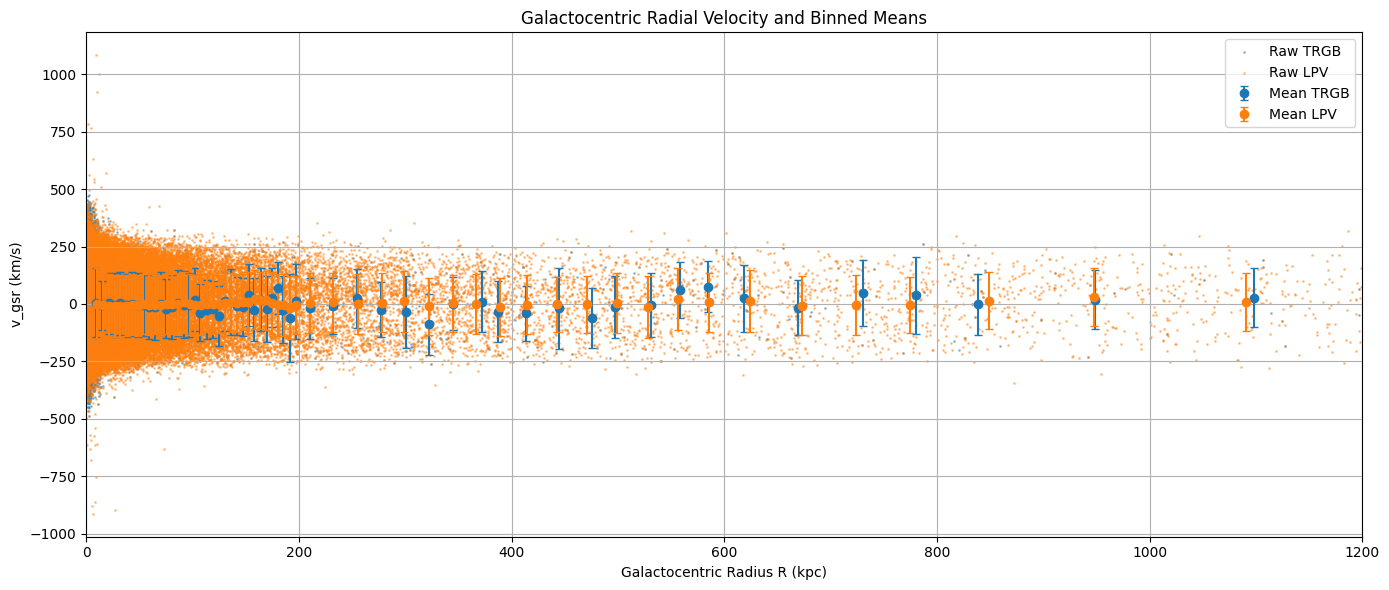

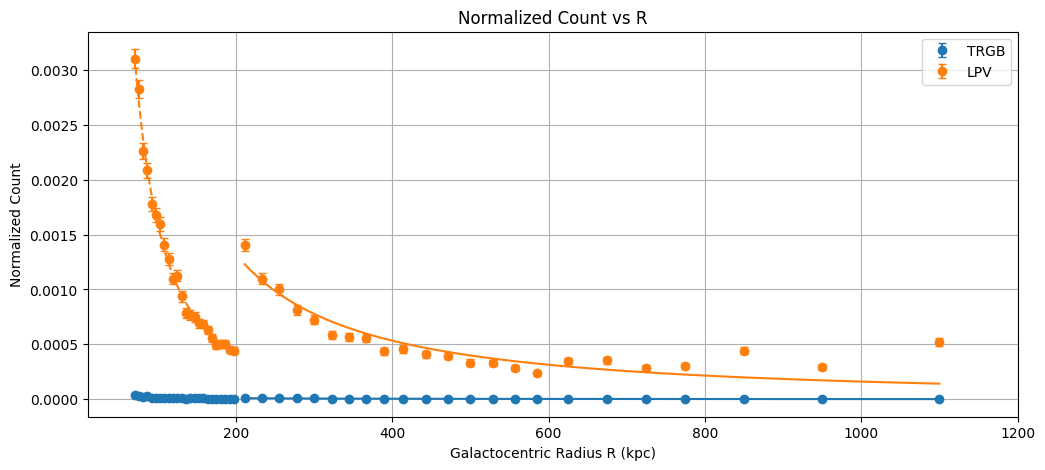

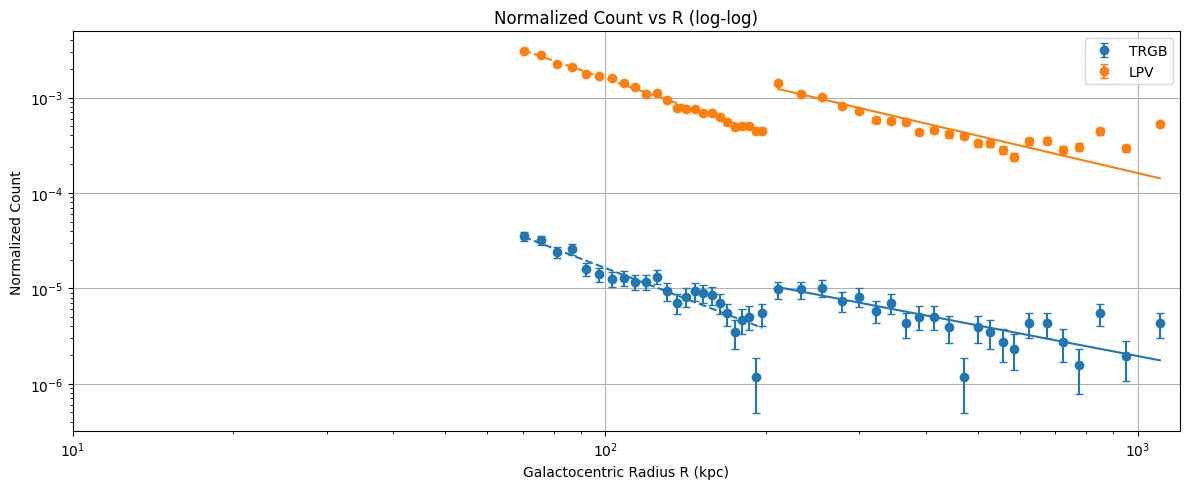


Fitted Parameters for n_tr (Normalized Counts):
[TRGB] <200: a = 7.12124e-05, b = -2.12606
[TRGB] ≥200: a = 4.80913e-05, b = -1.07030
[LPV] <200: a = 6.00299e-03, b = -1.92185
[LPV] ≥200: a = 8.06308e-03, b = -1.30571


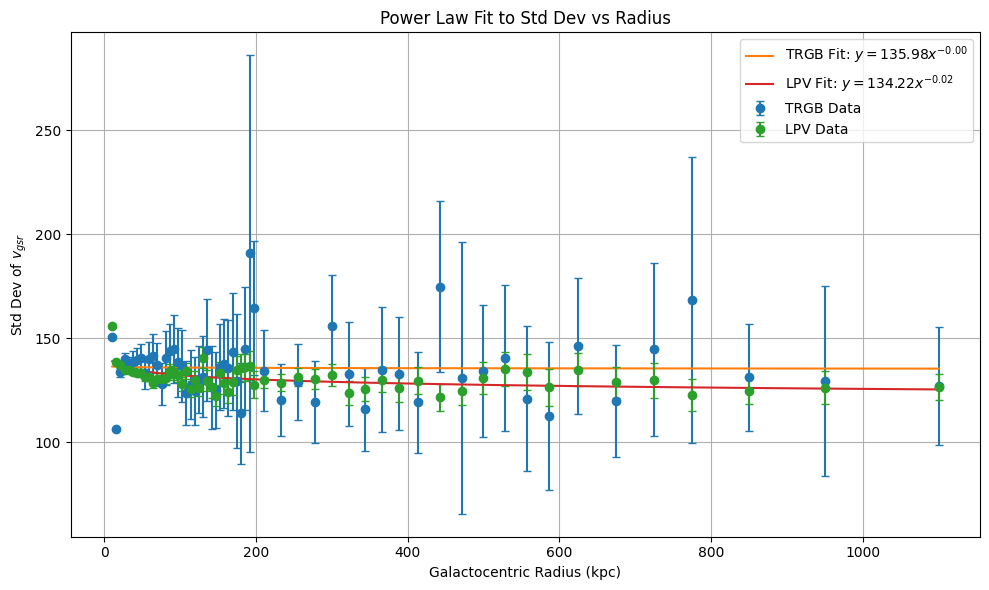

KeyError: 'TRGB'

<Figure size 1000x600 with 0 Axes>


=== Normalized Count Power-Law Parameters ===
      0     1         2         3
0  TRGB  <200  0.000071 -2.126058
1  TRGB  ≥200  0.000048 -1.070300
2   LPV  <200  0.006003 -1.921848
3   LPV  ≥200  0.008063 -1.305712

=== Velocity Dispersion Power-Law Parameters ===
      0           1         2
0  TRGB  135.983302 -0.001571
1   LPV  134.220520 -0.022233


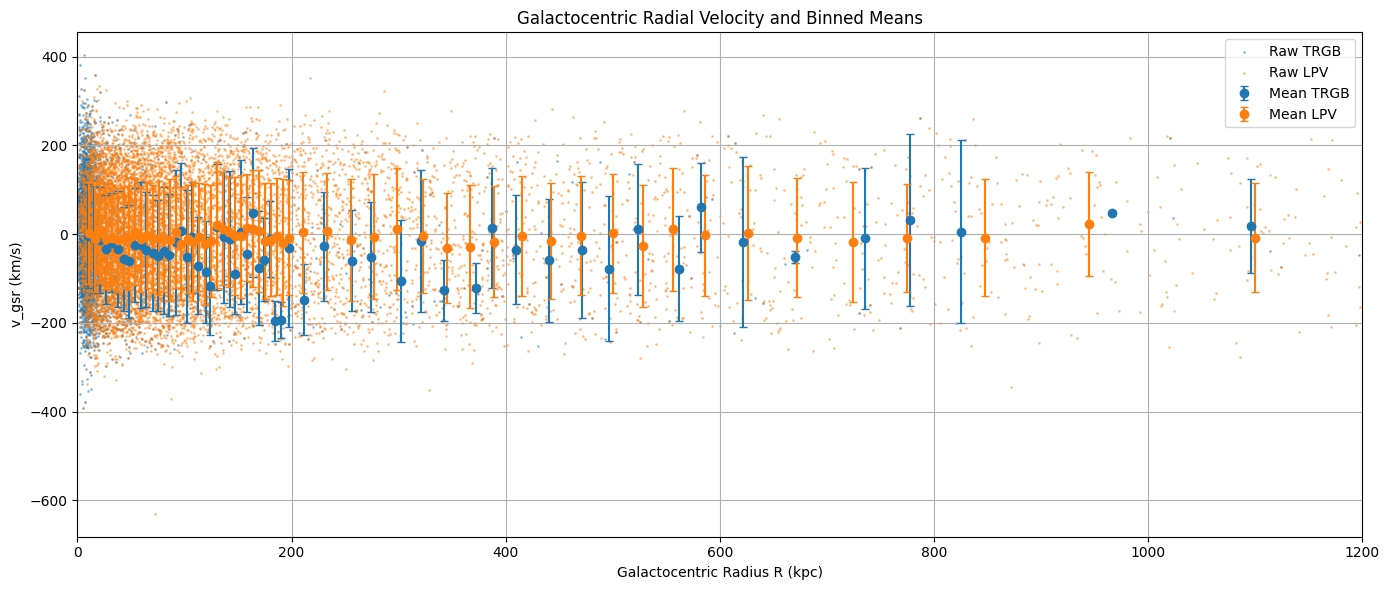

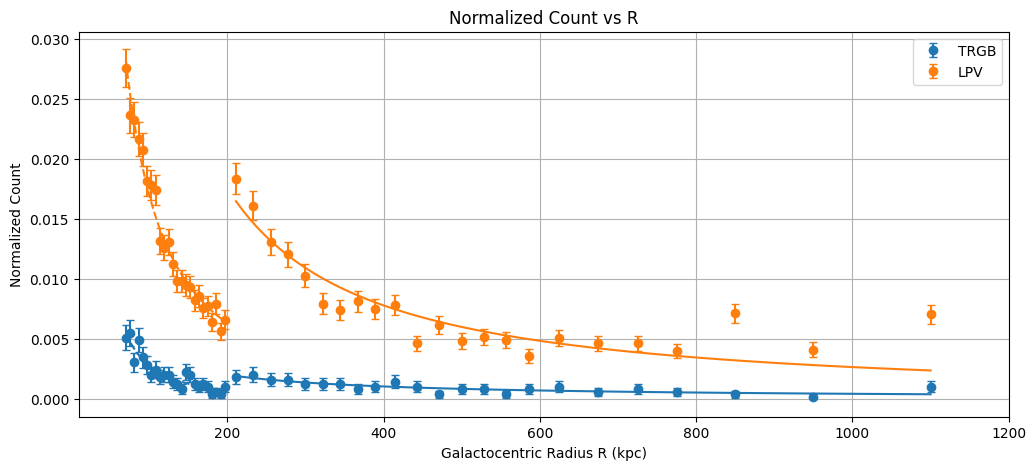

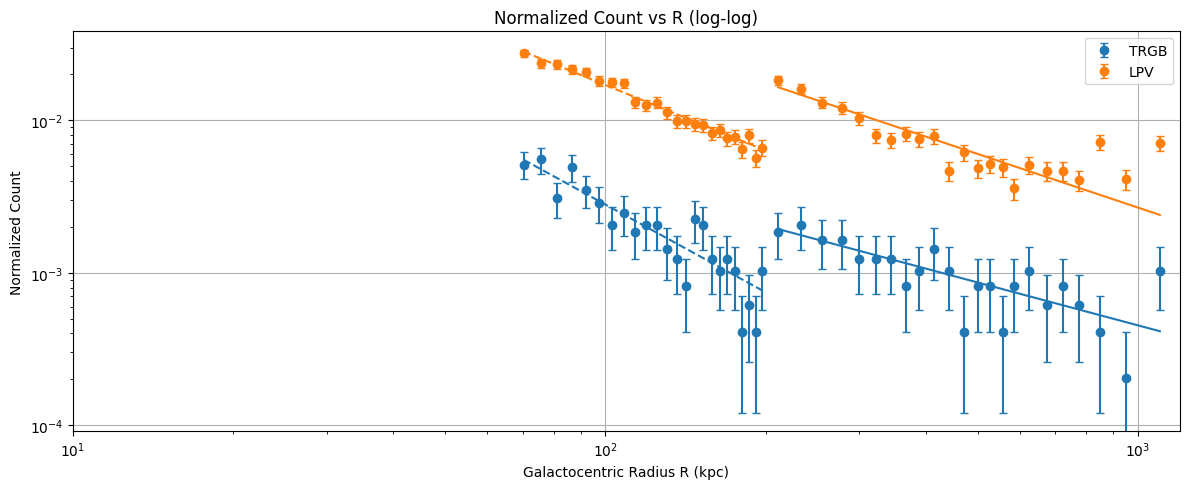


Fitted Parameters for n_tr (Normalized Counts):
[TRGB] <200: a = 1.05629e-02, b = -1.91347
[TRGB] ≥200: a = 7.43955e-03, b = -0.93513
[LPV] <200: a = 4.58821e-02, b = -1.42767
[LPV] ≥200: a = 8.88258e-02, b = -1.16888


MemoryError: Unable to allocate 20.1 MiB for an array with shape (2634866,) and data type float64

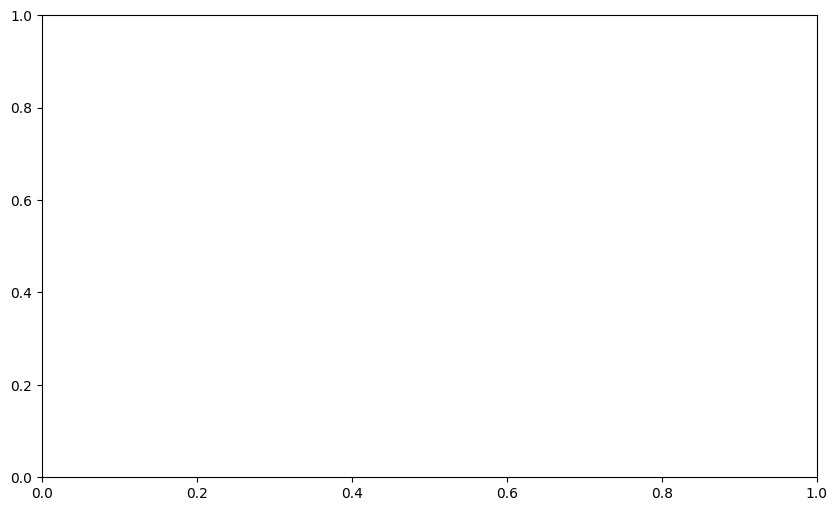

In [1]:
import numpy as np
import pandas as pd
import astropy.units as u
from astropy.coordinates import SkyCoord, Galactocentric
from scipy.stats import binned_statistic
from scipy.optimize import curve_fit
import matplotlib.pyplot as plt

# Constants
U_sun, V_sun, W_sun = 11.1 * u.km/u.s, 12.24 * u.km/u.s, 7.25 * u.km/u.s
V0, R0 = 229 * u.km/u.s, 8.1 * u.kpc
beta = 0.0  # velocity anisotropy

# Coordinate transformation
def transform_to_galactocentric(df):
    ra, dec = df['ra'].values * u.deg, df['dec'].values * u.deg
    d = (df['parallax'].values * u.mas).to(u.kpc, u.parallax())
    pm_ra, pm_dec = df['pmra'].values * u.mas/u.yr, df['pmdec'].values * u.mas/u.yr
    rv = df['radial_velocity'].values * u.km/u.s
    l, b = df['l'].values * u.deg, df['b'].values * u.deg
    c = SkyCoord(ra=ra, dec=dec, distance=d, pm_ra_cosdec=pm_ra, pm_dec=pm_dec, radial_velocity=rv)
    g = c.transform_to(Galactocentric(galcen_distance=R0, z_sun=0.020 * u.kpc, galcen_v_sun=[U_sun, V_sun, W_sun]))
    x, y , z = g.x.value, g.y.value ,g.z.value
    R = np.sqrt(x**2 + y**2)
    v_gsr = rv + U_sun*np.cos(b)*np.cos(l) + V_sun*np.cos(b)*np.sin(l) + W_sun*np.sin(b) + V0*np.cos(b)*np.sin(l)
    r = np.sqrt(R0.value**2 + d.value**2 - 2*R0.value*d.value*np.cos(b)*np.cos(l))
    v_c=(R/R0)*((v_gsr/(np.sin(l)*np.cos(b))+V0))
    return R, v_gsr.value, r ,v_c,z

def power_law(x, a, b):
    return a * (x / 50)**b

def process_file(file_path, label, custom_bins):
    df = pd.read_csv(file_path)
    R, v_gsr, r, v_c , z = transform_to_galactocentric(df)

    mask = ~np.isnan(R) & ~np.isnan(v_gsr) & (R <= custom_bins[-1]) & (np.abs(z)>5 )& ~(z<0)
    R, v_gsr = R[mask], v_gsr[mask]
    mean_x, _, _ = binned_statistic(R, R, bins=custom_bins, statistic='mean')
    mean_y, _, _ = binned_statistic(R, v_gsr, bins=custom_bins, statistic='mean')
    std_y, _, _ = binned_statistic(R, v_gsr, bins=custom_bins, statistic='std')
    count, _, _ = binned_statistic(R, v_gsr, bins=custom_bins, statistic='count')
    bin_centers = 0.5 * (custom_bins[:-1] + custom_bins[1:])
    return R, v_gsr, pd.DataFrame({
        'Bin Center': bin_centers, 'Mean X': mean_x, 'Mean Y': mean_y,
        'Std Y': std_y, 'Num Points': count, 'Label': label
    }).dropna()

file_configs = [
    {
        'path': 'TRGB_Gaia_new-result.csv', 'label': 'TRGB',
        'bins': np.concatenate([
            np.linspace(8, 100, 18), np.linspace(100, 150, 10)[1:], np.linspace(150, 200, 10)[1:],
            np.linspace(200, 400, 10)[1:], np.linspace(400, 600, 8)[1:],
            np.linspace(600, 800, 5)[1:], np.linspace(800, 1000, 3)[1:], np.linspace(1000, 1200, 2)[1:]
        ])
    },
    {
        'path': 'LPV_Gaia_new-result.csv', 'label': 'LPV',
        'bins': np.concatenate([
            np.linspace(8, 100, 18), np.linspace(100, 150, 10)[1:], np.linspace(150, 200, 10)[1:],
            np.linspace(200, 400, 10)[1:], np.linspace(400, 600, 8)[1:],
            np.linspace(600, 800, 5)[1:], np.linspace(800, 1000, 3)[1:], np.linspace(1000, 1200, 2)[1:]
        ])
    }
]

# Plot 1: v_gsr and binned means
plt.figure(figsize=(14, 6))
for config in file_configs:
    R, v_gsr, binned = process_file(config['path'], config['label'], config['bins'])
    plt.scatter(R, v_gsr, s=1, alpha=0.4, label=f'Raw {config["label"]}')
    plt.errorbar(binned['Mean X'], binned['Mean Y'], yerr=binned['Std Y'], fmt='o', capsize=3, label=f'Mean {config["label"]}')
plt.xlabel('Galactocentric Radius R (kpc)')
plt.ylabel('v_gsr (km/s)')
plt.title('Galactocentric Radial Velocity and Binned Means')
plt.xlim(0, 1200)
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

# Normalized Count plots and fits
fit_params_ntr, fit_params_sigma, fit_params = [], [], {}
fig3, ax3 = plt.subplots(figsize=(12, 5))
fig4, ax4 = plt.subplots(figsize=(12, 5))
colors = ['tab:blue', 'tab:orange']

for i, config in enumerate(file_configs):
    R, v_gsr, binned_df = process_file(config['path'], config['label'], config['bins'])
    color = colors[i % len(colors)]
    r_bin = binned_df['Bin Center'].values
    n_tr = binned_df['Num Points'].values / len(R)
    valid_mask = r_bin >= 70
    r_bin_valid, n_tr_valid = r_bin[valid_mask], n_tr[valid_mask]
    r_bin_low, n_tr_low = r_bin_valid[r_bin_valid < 200], n_tr_valid[r_bin_valid < 200]
    r_bin_high, n_tr_high = r_bin_valid[r_bin_valid >= 200], n_tr_valid[r_bin_valid >= 200]
    popt_low, _ = curve_fit(power_law, r_bin_low, n_tr_low, p0=(1, 1))
    popt_high, _ = curve_fit(power_law, r_bin_high, n_tr_high, p0=(1, 1))
    fit_params_ntr += [(config['label'], '<200', *popt_low), (config['label'], '≥200', *popt_high)]
    fit_params[config['label']] = {'b_low': popt_low[1], 'b_high': popt_high[1]}
    x_fit_low = np.linspace(r_bin_low.min(), r_bin_low.max(), 100)
    x_fit_high = np.linspace(r_bin_high.min(), r_bin_high.max(), 100)
    y_fit_low = power_law(x_fit_low, *popt_low)
    y_fit_high = power_law(x_fit_high, *popt_high)
    ax3.errorbar(r_bin_valid, n_tr_valid, yerr=np.sqrt(n_tr_valid/len(R)), fmt='o', capsize=3, label=f'{config["label"]}', color=color)
    ax3.plot(x_fit_low, y_fit_low, '--', color=color)
    ax3.plot(x_fit_high, y_fit_high, '-', color=color)
    ax4.errorbar(r_bin_valid, n_tr_valid, yerr=np.sqrt(n_tr_valid/len(R)), fmt='o', capsize=3, label=f'{config["label"]}', color=color)
    ax4.plot(x_fit_low, y_fit_low, '--', color=color)
    ax4.plot(x_fit_high, y_fit_high, '-', color=color)

for ax, title, ylab, xlog, ylog in zip([ax3, ax4], ['Normalized Count vs R', 'Normalized Count vs R (log-log)'], ['Normalized Count']*2, [False, True], [False, True]):
    ax.set_xlabel('Galactocentric Radius R (kpc)')
    ax.set_ylabel(ylab)
    ax.set_title(title)
    ax.legend()
    ax.grid(True)
    if xlog: ax.set_xscale('log')
    if ylog: ax.set_yscale('log')
    ax.set_xlim(10, 1200)
plt.tight_layout()
plt.show()

print("\nFitted Parameters for n_tr (Normalized Counts):")
for label, region, a, b in fit_params_ntr:
    print(f"[{label}] {region}: a = {a:.5e}, b = {b:.5f}")

# Fit to Std Dev vs Radius
fig_sigma, ax_sigma = plt.subplots(figsize=(10, 6))
for config in file_configs:
    _, _, binned = process_file(config['path'], config['label'], config['bins'])
    r_bin, s_gsr = binned['Bin Center'].values, binned['Std Y'].values
    N = binned['Num Points'].values
    error_bars = np.sqrt(1 / (2 * (N - 1))) * s_gsr
    popt, _ = curve_fit(power_law, r_bin, s_gsr, p0=(1, 1))
    fitted_a, fitted_b = popt
    fit_params[config['label']]['b_s'] = fitted_b
    x_fit, y_fit = np.linspace(min(r_bin), max(r_bin), 100), power_law(np.linspace(min(r_bin), max(r_bin), 100), fitted_a, fitted_b)
    ax_sigma.errorbar(r_bin, s_gsr, yerr=error_bars, fmt='o', label=f'{config["label"]} Data', capsize=3)
    ax_sigma.plot(x_fit, y_fit, label=f'{config["label"]} Fit: $y = {fitted_a:.2f} x^{{{fitted_b:.2f}}}$')
    fit_params_sigma.append((config['label'], fitted_a, fitted_b))
ax_sigma.set_xlabel('Galactocentric Radius (kpc)')
ax_sigma.set_ylabel('Std Dev of $v_{gsr}$')
ax_sigma.set_title('Power Law Fit to Std Dev vs Radius')
ax_sigma.legend()
ax_sigma.grid(True)
plt.tight_layout()
plt.show()

# V_c computation
def compute_v_c(r, std_y, N, b_low, b_high, b_s):
    H_r = (r**2 + R0**2) / (4 * r**2) - ((r**2 - R0**2)**2) / (8 * r**3 * R0) * np.log(abs((r + R0) / (r - R0)))
    sigma_r = std_y / np.sqrt(1 - beta * H_r)
    dln_ntr_dlR = np.where(r.value < 200, b_low, b_high)
    dln_sigma_r2_dlR = b_s
    V_c = np.sqrt(np.abs(-sigma_r**2 * (dln_ntr_dlR + dln_sigma_r2_dlR + 2 * beta)))
    error_sigma_r = np.sqrt(1 / (2 * (N - 1))) * sigma_r
    error_V_c = np.sqrt((2 * sigma_r * error_sigma_r / V_c)**2 + (sigma_r**2 / (V_c * N))**2)
    return r, V_c, error_V_c

plt.figure(figsize=(10, 6))
for config in file_configs:
    _, _, binned_df = process_file(config['path'], config['label'], config['bins'])
    r_vals, std_vals, N_vals = binned_df['Bin Center'].values, binned_df['Std Y'].values, binned_df['Num Points'].values
    r_vals_q, std_vals_q = r_vals * u.kpc, std_vals * u.km/u.s
    b_low, b_high, b_s = fit_params[config['label']]['b_low'], fit_params[config['label']]['b_high'], fit_params[config['label']]['b_s']
    r_plot, V_c_vals, V_c_err = compute_v_c(r_vals_q, std_vals_q, N_vals, b_low, b_high, b_s)
    plt.errorbar(r_plot.value, V_c_vals, yerr=V_c_err, fmt='o', capsize=3, label=f'{config["label"]}')
plt.xlabel('Galactocentric Radius (kpc)')
plt.ylabel('Circular Velocity $V_c$ (km/s)')
plt.title('Circular Velocity Profile')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.ylim(-100,500)
plt.show()


In [3]:
fit_df = pd.DataFrame(fit_params_ntr)
sigma_df = pd.DataFrame(fit_params_sigma)

print("\n=== Normalized Count Power-Law Parameters ===")
print(fit_df)
print("\n=== Velocity Dispersion Power-Law Parameters ===")
print(sigma_df)


=== Normalized Count Power-Law Parameters ===
      0     1         2         3
0  TRGB  <200  0.000071 -2.126058
1  TRGB  ≥200  0.000048 -1.070300
2   LPV  <200  0.006003 -1.921848
3   LPV  ≥200  0.008063 -1.305712

=== Velocity Dispersion Power-Law Parameters ===
      0           1         2
0  TRGB  135.983302 -0.001571
1   LPV  134.220520 -0.022233


0.5

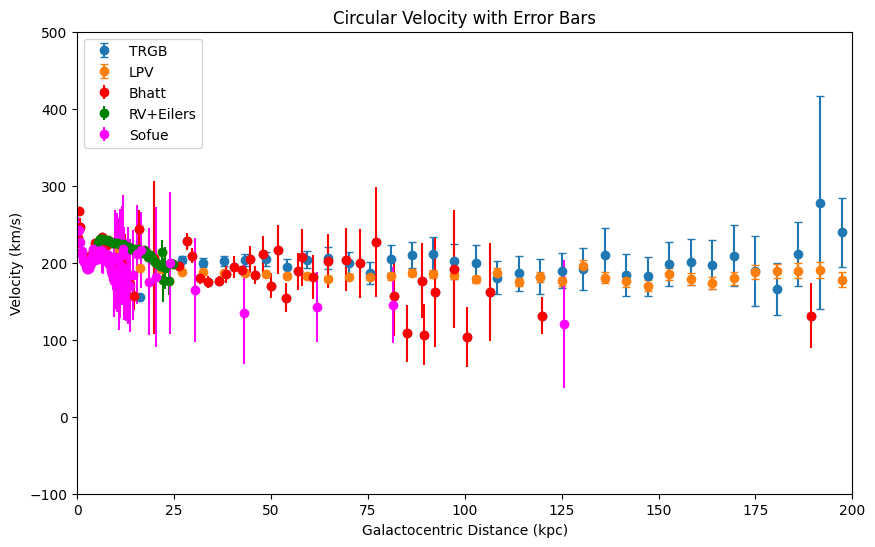

In [11]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import binned_statistic

# V_c computation
def compute_v_c(r, std_y, N, b_low, b_high, b_s):
    beta=0.0
    H_r = (r**2 + R0**2) / (4 * r**2) - ((r**2 - R0**2)**2) / (8 * r**3 * R0) * np.log(abs((r + R0) / (r - R0)))
    sigma_r = std_y / np.sqrt(1 - beta * H_r)
    dln_ntr_dlR = np.where(r.value < 200, b_low, b_high)
    dln_sigma_r2_dlR = b_s
    V_c = np.sqrt(np.abs(-sigma_r**2 * (dln_ntr_dlR + dln_sigma_r2_dlR + 2 * beta)))
    error_sigma_r = np.sqrt(1 / (2 * (N - 1))) * sigma_r
    error_V_c = np.sqrt((2 * sigma_r * error_sigma_r / V_c)**2 + (sigma_r**2 / (V_c * N))**2)
    return r, V_c, error_V_c

plt.figure(figsize=(10, 6))
for config in file_configs:
    _, _, binned_df = process_file(config['path'], config['label'], config['bins'])
    r_vals, std_vals, N_vals = binned_df['Bin Center'].values, binned_df['Std Y'].values, binned_df['Num Points'].values
    r_vals_q, std_vals_q = r_vals * u.kpc, std_vals * u.km/u.s
    b_low, b_high, b_s = fit_params[config['label']]['b_low'], fit_params[config['label']]['b_high'], fit_params[config['label']]['b_s']
    r_plot, V_c_vals, V_c_err = compute_v_c(r_vals_q, std_vals_q, N_vals, b_low, b_high, b_s)
    plt.errorbar(r_plot.value, V_c_vals, yerr=V_c_err, fmt='o', capsize=3, label=f'{config["label"]}')

data = np.loadtxt('bhatt_all.txt')
        


        # Extract x and y columns
x, y, e = data[:51, 2], data[:51, 3], data[:51, 4]


        # Plot the data

plt.scatter(x, y)
plt.errorbar(x, y,yerr=e, fmt='o', color='r', label='Bhatt')

data1 = np.loadtxt('MW_rotation_Eilers_2019.txt')
        


        # Extract x and y columns
x1, y1,e1 = data1[:, 0], data1[:, 1] ,data1[:,2]

        # Plot the data

plt.scatter(x1, y1)
plt.errorbar(x1, y1,yerr=e1, fmt='o', color='g', label='RV+Eilers')

data3 = np.loadtxt('Sofue.txt')

x3, y3, e3 = data3[:, 0], data3[:, 1] ,data3[:,2]

#plt.scatter(x3,y3, color='magenta', label='Sofue')
#plt.fill_between(x3, y3-e3, y3+e3, alpha=0.2, facecolor='magenta')
plt.errorbar(x3, y3, yerr=e3, fmt='o', color='magenta', label='Sofue')

#plt.xscale('log')

#plt.xlim(0, 500)
plt.ylim(-100, 500)


# Plot formatting

plt.xlabel('Galactocentric Distance (kpc)')
plt.ylabel('Velocity (km/s)')
plt.title('Circular Velocity with Error Bars')
plt.legend()
plt.xlim(0,200)
plt.show()



